# Visual prompting component implementation

In [27]:
import torch
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [23]:
print(f"GPU available: {torch.cuda.is_available()}, Device: {torch.cuda.get_device_properties(torch.cuda.current_device()).name}")
device = "cuda" if torch.cuda.is_available() else "cpu"

GPU available: True, Device: NVIDIA A100-SXM4-40GB


# Object box

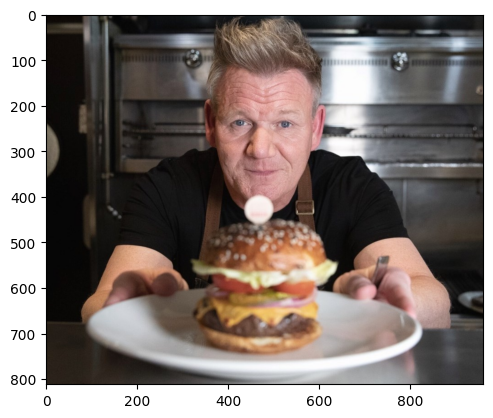

In [28]:
image = Image.open("./images/gordon-ramsay-burger.jpg")
plt.imshow(image)
plt.show()


0: 544x640 1 person, 1 sandwich, 10.6ms
Speed: 3.0ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


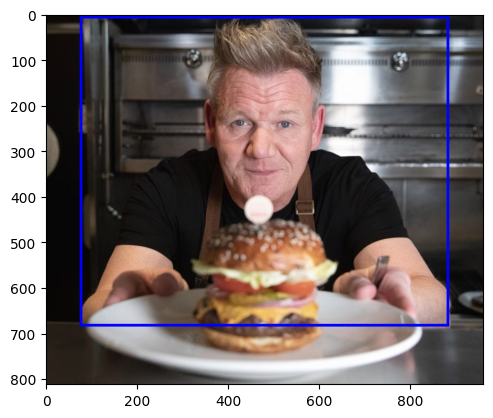

In [30]:
yolo = YOLO("yolo11n.pt")
results = yolo.predict(image)[0]
person_cls = 0
person_boxes = [box for box in results.boxes if int(box.cls) == person_cls]
person_box = person_boxes[0].xyxy[0].cpu().numpy().astype(int)

image_with_rectangle = image.copy()
draw = ImageDraw.Draw(image_with_rectangle)
draw.rectangle(person_box.tolist(), outline="blue", width=6)

plt.imshow(image_with_rectangle)
plt.show()